<h1 style="text-align:center;">Previsão do tipo de falha em motores

# <a id='sumario'></a>Sumário
1. [**Entendimento do problema**](#entendimento-do-problema)
2. [**Bibliotecas**](#bibliotecas)
<br>
3. [**Entendimento dos Dados**](#entendimento-dos-dados)       
- 3.1 [Carregando os Dados](#carregando-os-dados)
- 3.2 [Primeiras impressões dos dados](#primeiras-impressoes-dos-dados)
- 3.3 [Primeiras transformações nos dados](#primeiras-transformacoes-nos-dados)
4. [**Descritiva e Transformações dos Dados**](#descritiva-e-transformacoes-dos-dados)
- 4.1 [Univariadas](#univariadas)
- 4.2 [Bivariadas](#bivariada)
    - 4.2.1 [Categórica](#Categórica)
    - 4.2.2 [Continuas](#Continuas)
    - 4.2.3 ['Dummies'](#Dummies)
5. [**Planejamento do modelo**](#planejamento-do-modelo)
- 5.1 [Setup](#Setup)
- 5.2 [Cross Validation](#CV)
6. [**LGBM**](#LGBM)
- 6.1 [LGBM model](#LGBM-model)
<br>
7. [**Modelo Final**](#modelo-final)<br>
- 7.1 [create_model](#create_model)
- 7.2 [Predict e Pipeline](#predict)
<br>
8. [**Avaliação do Modelo**](#aval-modelo)
9. [**Relatório Gerencial**](#relatorio)
- 9.1 [SHAP](#SHAP)

<a id='entendimento-do-problema'></a>
# 1. Entendimento do problema

A manutenção preditiva é uma parte crucial do processo produtivo. Ela permite que as empresas identifiquem problemas potenciais em suas máquinas antes que eles causem falhas significativas, levando a interrupções na produção e custos de reparo elevados. Ao prever quando uma máquina pode falhar, as empresas podem planejar a manutenção de forma eficaz, minimizando o tempo de inatividade e maximizando a eficiência da produção.

Este conjunto de dados apresenta um problema de classificação multiclasses, onde o objetivo é prever o tipo de falha que ocorrerá com base em várias características do processo. As características incluem temperatura do ar, temperatura do processo, velocidade de rotação, torque, desgaste da ferramenta, entre outros.

Existem cinco tipos de falhas possíveis:

1. **Falha de desgaste da ferramenta (TWF)**: ocorre quando a ferramenta atinge um tempo de desgaste selecionado aleatoriamente entre 200 - 240 minutos.
2. **Falha de dissipação de calor (HDF)**: ocorre quando a diferença entre a temperatura do ar e do processo é inferior a 8,6 K e a velocidade de rotação da ferramenta é inferior a 1380 rpm.
3. **Falha de energia (PWF)**: ocorre quando o produto do torque e da velocidade de rotação (em rad/s) é inferior a 3500 W ou superior a 9000 W.
4. **Falha de sobrecarga (OSF)**: ocorre quando o produto do desgaste da ferramenta e do torque excede 11.000 minNm para a variante do produto L (12.000 M, 13.000 H).
5. **Falhas aleatórias (RNF)**: cada processo tem uma chance de 0,1% de falhar, independentemente de seus parâmetros de processo.
6. **Sem falha**: quando não há falha alguma.

A intenção é prever para novos dados se o motor está em falha e qual o tipo dela. Além disso, caso o motor não esteja em falha, queremos prever qual será a variação das variáveis (tempo, temperatura, aumento de torque) para cada tipo de falha. Isso nos permitirá entender o quanto esse motor ainda aguenta e estimar quando ele irá falhar.

<a id='bibliotecas'></a>
# 2. Bibliotecas
   
[Voltar ao índice](#Contents)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly.graph_objects as go
import plotly.subplots as sp
import statsmodels.api as sm

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from pycaret.classification import *
from ydata_profiling import ProfileReport

%matplotlib inline

<a id='entendimento-dos-dados'></a>
# 3. Entendimento dos Dados

Os dados que temos são provenientes de **sensores** que foram capturados em um dado momento para **três tipos de ferramentas**. Cada ferramenta é identificada por um **ID de produto** único, que consiste em uma letra (L, M ou H) representando a variante de qualidade do produto (baixa, média ou alta) e um número de série específico da variante.

As características capturadas pelos sensores incluem:

- **Temperatura do ar [K]**: Esta é a temperatura do ar medida em Kelvin. Foi gerada usando um processo de passeio aleatório e posteriormente normalizada para um desvio padrão de 2 K em torno de 300 K.
- **Temperatura do processo [K]**: Esta é a temperatura do processo, também medida em Kelvin. Foi gerada de maneira semelhante à temperatura do ar, mas com um desvio padrão de 1 K, e é adicionada à temperatura do ar mais 10 K.
- **Velocidade de rotação [rpm]**: Esta é a velocidade de rotação da ferramenta, calculada a partir de uma potência de 2860 W e sobreposta com um ruído normalmente distribuído.
- **Torque [Nm]**: Os valores de torque são normalmente distribuídos em torno de 40 Nm com um SD = 10 Nm e sem valores negativos.
- **Desgaste da ferramenta [min]**: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta usada no processo.

Além disso, temos um rótulo de **'falha da máquina'** que indica se a máquina falhou neste ponto de dados específico. A falha da máquina consiste em seis modos de falha independentes: falha de desgaste da ferramenta (TWF), falha de dissipação de calor (HDF), falha de energia (PWF), falha de sobrecarga (OSF), falhas aleatórias (RNF), e Sem falha (No Failure).

Nosso objetivo é usar esses dados para prever o tipo de falha que ocorrerá, ou se não ocorrerá falha, com base nas características do processo. Isso nos permitirá realizar manutenção preditiva, minimizando o tempo de inatividade e maximizando a eficiência da produção.

| Variáveis | Descrição |
|-----------|-----------|
| UID | Identificador único variando de 1 a 10000 |
| ID do produto | Consiste em uma letra L, M ou H para baixa (50% de todos os produtos), média (30%) e alta (20%) como variantes de qualidade do produto e um número de série específico da variante |
| tipo | Apenas o tipo de produto L, M ou H da coluna 2 |
| temperatura do ar [K] | Gerada usando um processo de passeio aleatório posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K |
| temperatura do processo [K] | Gerada usando um processo de passeio aleatório normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K |
| velocidade de rotação [rpm] | Calculada a partir de uma potência de 2860 W, sobreposta com um ruído normalmente distribuído |
| torque [Nm] | Os valores de torque são normalmente distribuídos em torno de 40 Nm com um SD = 10 Nm e sem valores negativos |
| desgaste da ferramenta [min] | As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta usada no processo |
| falha da máquina | Um rótulo que indica se a máquina falhou neste ponto de dados específico para qualquer um dos seguintes modos de falha é verdadeiro |
| Classes | A falha da máquina consiste em seis modos de falha independentes: falha de desgaste da ferramenta (TWF), falha de dissipação de calor (HDF), falha de energia (PWF), falha de sobrecarga (OSF), falhas aleatórias (RNF), Sem falha (No Failure) |

- A variável **'desgaste da ferramenta[min]'** deixa em duvida se a cada um minuto de processo, a ferramenta ganha 5/3/2 minutos de desgaste. Ou o contrário, porém sem mais informações, vamos inferir que seja um desgaste de 5/3/2 para cada minuto de processo.

<a id='carregando-os-dados'></a>
## 3.1 Carregando os Dados
     
[Voltar ao índice](#Contents)

Os dados já se encontram separados em treino e teste

In [3]:
# Carregando o Data Frame de Treino
df_treino = pd.read_csv("manutencao_preditiva_treino.csv")

# Carregando o Data Frame de Test
df_teste = pd.read_csv("manutencao_preditiva_teste.csv")

<a id='primeiras-impressoes-dos-dados'></a>
## 3.2 Primeiras imprensões dos dados

In [4]:
# Cria um relatório de perfil de dados para df_train
profile = ProfileReport(df_treino)

# Gera o relatório no próprio Jupyter Notebook
profile.to_notebook_iframe()

In [5]:
# Informações sobre o Data Frame
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   udi                    6667 non-null   int64  
 1   product_id             6667 non-null   object 
 2   type                   6667 non-null   object 
 3   air_temperature_k      6667 non-null   float64
 4   process_temperature_k  6667 non-null   float64
 5   rotational_speed_rpm   6667 non-null   int64  
 6   torque_nm              6667 non-null   float64
 7   tool_wear_min          6667 non-null   int64  
 8   failure_type           6667 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 468.9+ KB


In [6]:
df_treino.head()

udi product_id type  air_temperature_k  process_temperature_k  \
0    1     M14860    M              298.1                  308.6   
1    2     L47181    L              298.2                  308.7   
2    5     L47184    L              298.2                  308.7   
3    6     M14865    M              298.1                  308.6   
4    7     L47186    L              298.1                  308.6   

   rotational_speed_rpm  torque_nm  tool_wear_min failure_type  
0                  1551       42.8              0   No Failure  
1                  1408       46.3              3   No Failure  
2                  1408       40.0              9   No Failure  
3                  1425       41.9             11   No Failure  
4                  1558       42.4             14   No Failure

<a id='balanceamento-classes'></a>
## 3.3 Balanceamento das classes

Apenas para anotação já que a maioria dos algoritmos de classificação multiclasse não sofrem com desbalancemaneto

In [7]:
# Contagem de valores para a coluna 'failure_type'
contagem = df_treino['failure_type'].value_counts()

# Porcentagem de cada classe
porcentagem = df_treino['failure_type'].value_counts(normalize=True) * 100

print("Contagem de classes:\n", contagem)
print("\nPorcentagem de classes:\n", porcentagem)

Contagem de classes:
 No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Porcentagem de classes:
 No Failure                  96.520174
Heat Dissipation Failure     1.124944
Power Failure                0.944953
Overstrain Failure           0.779961
Tool Wear Failure            0.449978
Random Failures              0.179991
Name: failure_type, dtype: float64


<a id='primeiras-transformacoes-nos-dados'></a>
## 3.3 Primeiras transformações nos dados

In [8]:
# Retirando colunas de ID
df_treino = df_treino.drop(['udi', 'product_id'], axis=1)

Como vimos a variável 'tool_wear_min' representa os minutos de desgaste de acordo com cada tipo, assim podemos inferir o tempo de processo de cada ferramenta naquele momento, pelo tipo e minutos de desgaste já que "As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta usada no processo". Assim iremos criar a coluna min_processo apenas para facilitar na conclusão e relatório gerencial.

In [9]:
def calcular_minutos_processo(row):
    if row['type'] == 'H':
        return row['tool_wear_min'] / 5 if row['tool_wear_min'] != 0 else 0
    elif row['type'] == 'M':
        return row['tool_wear_min'] / 3 if row['tool_wear_min'] != 0 else 0
    elif row['type'] == 'L':
        return row['tool_wear_min'] / 2 if row['tool_wear_min'] != 0 else 0
    else:
        return None

# Aplicar a função para criar a nova coluna 'min_processo'
df_treino['min_processo'] = df_treino.apply(calcular_minutos_processo, axis=1)

# Aplicar a função para criar a nova coluna 'min_processo'
df_teste['min_processo'] = df_treino.apply(calcular_minutos_processo, axis=1)

In [10]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   6667 non-null   object 
 1   air_temperature_k      6667 non-null   float64
 2   process_temperature_k  6667 non-null   float64
 3   rotational_speed_rpm   6667 non-null   int64  
 4   torque_nm              6667 non-null   float64
 5   tool_wear_min          6667 non-null   int64  
 6   failure_type           6667 non-null   object 
 7   min_processo           6667 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 416.8+ KB


<a id='descritiva-e-transformacoes-dos-dados'></a>
# 4. Descritiva e Transformações dos Dados

<a id='univariadas'></a>
## 4.1 Univariadas

In [11]:
def describe_continuous(df):
    # Alterar a formatação global de exibição de float
    pd.options.display.float_format = '{:.2f}'.format

    # Selecionar variáveis contínuas
    continuous_vars = df.select_dtypes(include=['int64','int32','float64'])

    # Obter estatísticas descritivas
    desc = continuous_vars.describe()

    # Adicionar uma linha para a quantidade de valores únicos
    unique_counts = pd.DataFrame(continuous_vars.nunique(), columns=['unique']).transpose()
    desc = pd.concat([desc, unique_counts])

    return desc

In [12]:
def describe_categorical(df):
    categorical_vars = df.select_dtypes(include=['object', 'bool'])
    return categorical_vars.describe()

In [13]:
# Estatisticas variáveis numéricas
describe_continuous(df_treino)

air_temperature_k  process_temperature_k  rotational_speed_rpm  \
count             6667.00                6667.00               6667.00   
mean               299.99                 309.99               1537.42   
std                  1.99                   1.49                177.18   
min                295.30                 305.70               1168.00   
25%                298.30                 308.80               1422.50   
50%                300.00                 310.00               1503.00   
75%                301.50                 311.10               1612.00   
max                304.50                 313.80               2886.00   
unique              93.00                  82.00                840.00   

        torque_nm  tool_wear_min  min_processo  
count     6667.00        6667.00       6667.00  
mean        40.06         108.10         45.56  
std          9.95          63.36         29.89  
min          3.80           0.00          0.00  
25%         33.20          54.00         20.55  
50%         40.20         108.00         41.40  
75%         46.80         162.00         67.50  
max         76.60         251.00        125.50  
unique     547.00         243.00        564.00

In [14]:
describe_categorical(df_treino)

type failure_type
count   6667         6667
unique     3            6
top        L   No Failure
freq    4022         6435

<a id='bivariada'></a>
## 4.2 Bivariadas

<a id='Categórica'></a>
### 4.2.1 Categórica

In [15]:
# Define as cores para cada tipo
cores = {'M': 'blue', 'L': 'red', 'H': 'green'}

# Obtém a lista de categorias dentro da variável 'type'
tipos = df_treino['type'].unique()

# Obtém a lista de categorias dentro da variável 'failure_type'
classes = df_treino['failure_type'].unique()

# Inicializa uma lista para os dados do gráfico
data_no_failure = []
data_other_classes = []

# Calcula a proporção de cada tipo para a classe 'No Failure'
for tipo in tipos:
    proporcao = len(df_treino[(df_treino['type'] == tipo) & (df_treino['failure_type'] == 'No Failure')]) / len(df_treino[df_treino['failure_type'] == 'No Failure'])
    data_no_failure.append(go.Bar(name=f'{tipo}_No Failure', x=['No Failure'], y=[proporcao], marker_color=cores[tipo]))

# Cria o layout do gráfico
layout_no_failure = go.Layout(title='Proporção de Classes por Tipo da Ferramenta (apenas No Failure)', barmode='group')

# Cria o objeto Figure e adiciona os dados e o layout
fig_no_failure = go.Figure(data=data_no_failure, layout=layout_no_failure)

# Mostra o gráfico
fig_no_failure.show()

# Agora, cria um gráfico separado para as outras classes

# Calcula a proporção de cada tipo para cada classe, excluindo 'No Failure'
for classe in classes:
    if classe != 'No Failure':
        for tipo in tipos:
            proporcao = len(df_treino[(df_treino['type'] == tipo) & (df_treino['failure_type'] == classe)]) / len(df_treino[df_treino['failure_type'] == classe])
            # Adiciona os dados ao gráfico
            # Ajusta a legenda para mostrar o tipo e a classe
            data_other_classes.append(go.Bar(name=f'{tipo}_{classe}', x=[classe], y=[proporcao], marker_color=cores[tipo]))

# Cria o layout do gráfico
layout_other_classes = go.Layout(title='Proporção de Classes por Tipo da Ferramenta (excluindo No Failure)', barmode='stack')

# Cria o objeto Figure e adiciona os dados e o layout
fig_other_classes = go.Figure(data=data_other_classes, layout=layout_other_classes)

# Mostra o gráfico
fig_other_classes.show()

- Vemos que o tipo de ferramenta H é proporcionalmente menor a incidência de falhas em praticamente todas as classes

In [16]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   type                   6667 non-null   object 
 1   air_temperature_k      6667 non-null   float64
 2   process_temperature_k  6667 non-null   float64
 3   rotational_speed_rpm   6667 non-null   int64  
 4   torque_nm              6667 non-null   float64
 5   tool_wear_min          6667 non-null   int64  
 6   failure_type           6667 non-null   object 
 7   min_processo           6667 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 416.8+ KB


<a id='Continuas'></a>
### 4.2.2 Continuas

#### Outliers

In [17]:
# Filtrar as colunas contínuas
continuous_columns = df_treino.select_dtypes(include=['int64', 'float64']).columns

# Para cada coluna contínua
for col in continuous_columns:
    Q1 = df_treino[col].quantile(0.25)
    Q3 = df_treino[col].quantile(0.75)
    IQR = Q3 - Q1

    # Definindo os limites para os outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identificando os outliers
    outliers = df_treino[(df_treino[col] < lower_bound) | (df_treino[col] > upper_bound)]

    # Imprimindo a quantidade de outliers
    print(f"Quantidade de outliers para {col}: {len(outliers)}")

Quantidade de outliers para air_temperature_k: 0
Quantidade de outliers para process_temperature_k: 0
Quantidade de outliers para rotational_speed_rpm: 269
Quantidade de outliers para torque_nm: 47
Quantidade de outliers para tool_wear_min: 0
Quantidade de outliers para min_processo: 0


In [18]:
# Retirando outliers
df_treino = df_treino.drop(outliers.index)

#### Distribuição e Bivariadas

<Figure size 1000x1000 with 0 Axes>

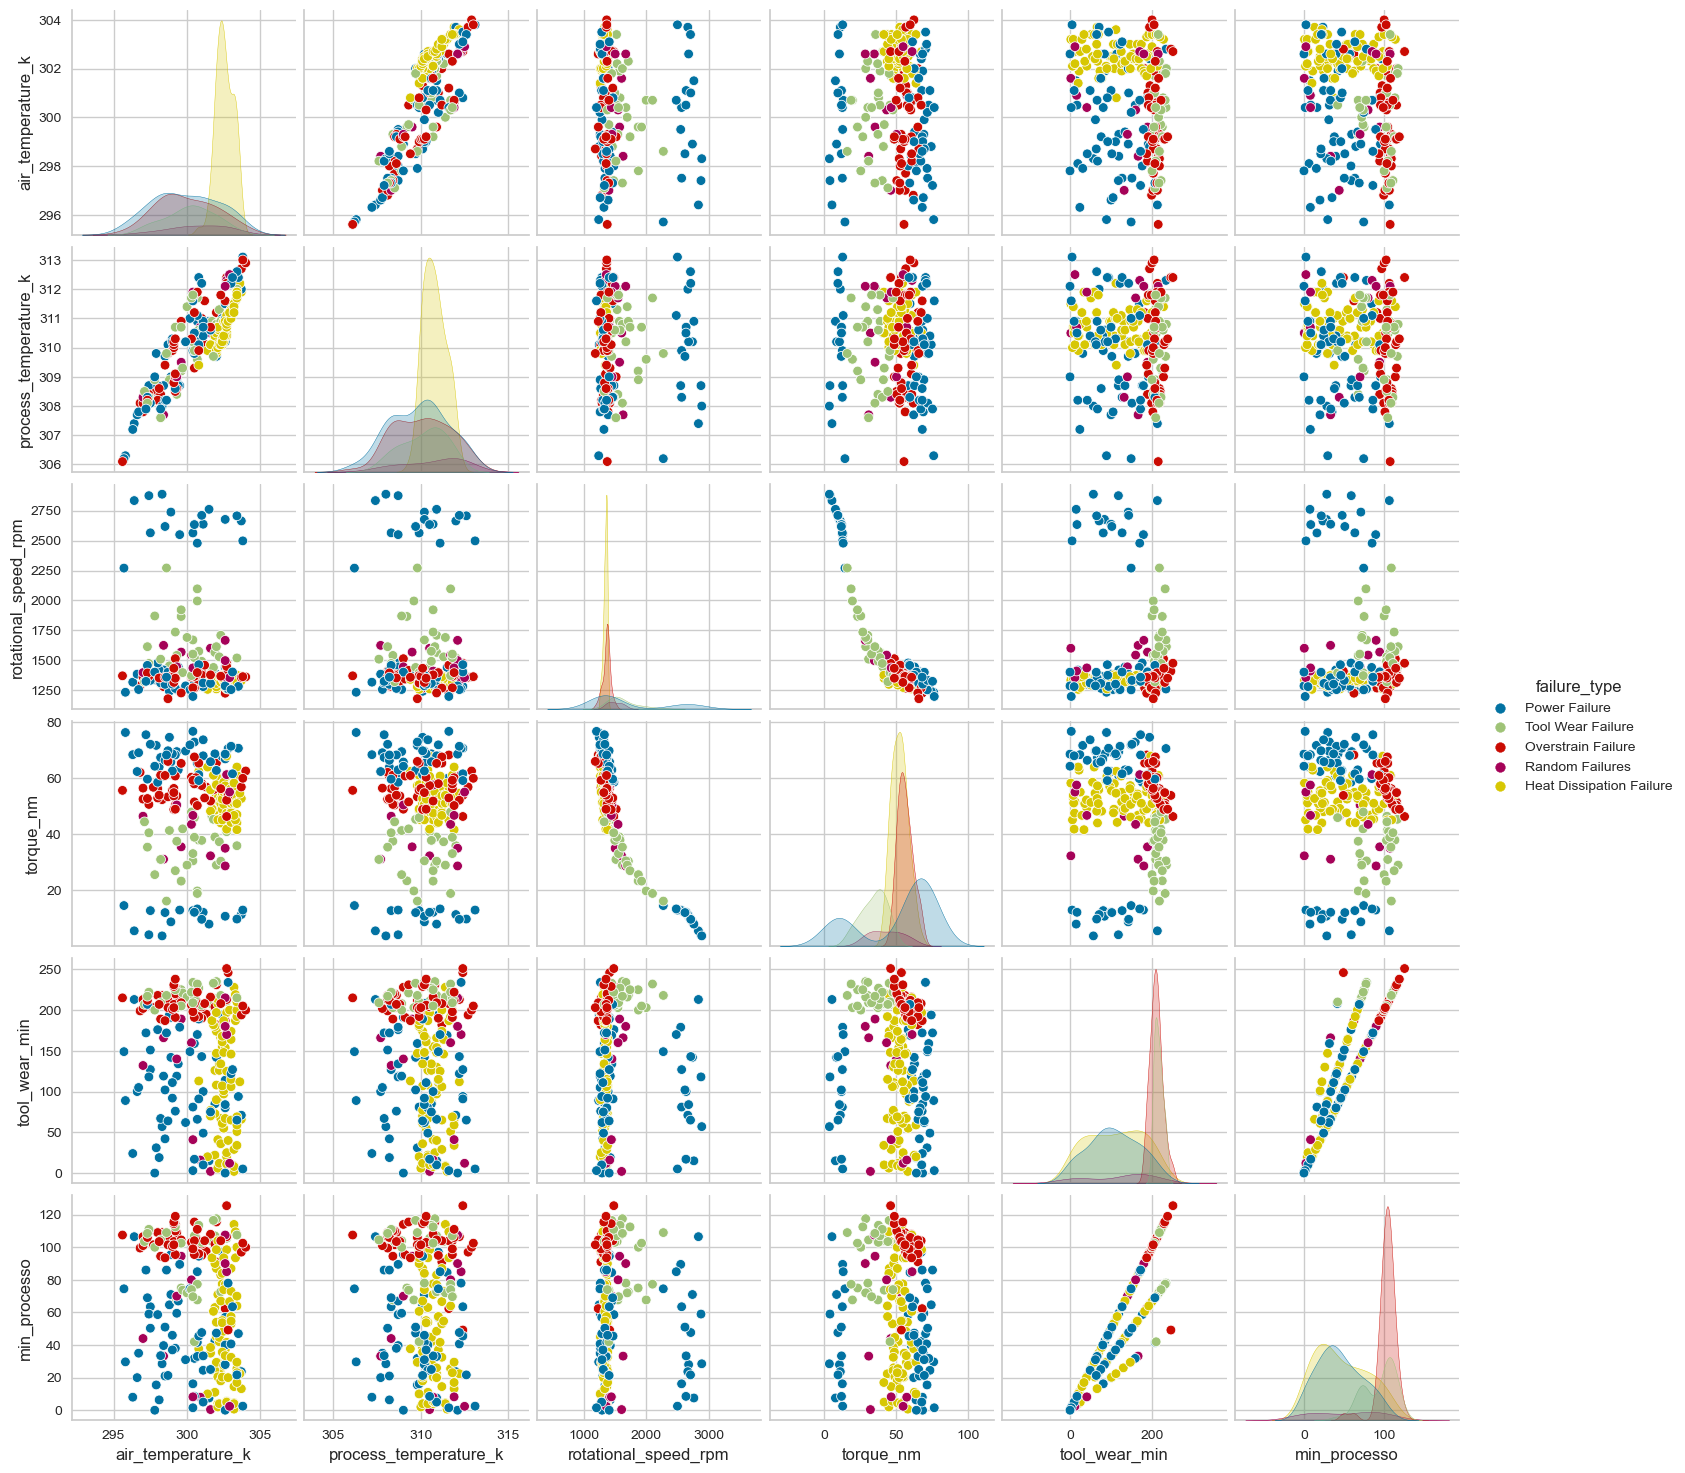

In [19]:
# Remover a classe "No Failure"
df_treino_no = df_treino[df_treino["failure_type"] != "No Failure"]

# Aumentar o tamanho da figura
plt.figure(figsize=(10, 10))

# Criar o pairplot
sns.pairplot(df_treino_no, hue="failure_type")

plt.show()

- Observamos alguma linearidade entre algumas variáveis em relação as classes da variável respsota, como a velocidade RPM e o Torque, o que faz bastante sentido físico.

#### Bivariada pela média

In [20]:
# Criar a figura e os subplots
fig = sp.make_subplots(rows=3, cols=2, subplot_titles=continuous_columns, horizontal_spacing=0.1, vertical_spacing=0.15)

# Para cada coluna contínua
for i, col in enumerate(continuous_columns):
    # Calcular a média para cada classe
    means = df_treino.groupby("failure_type")[col].mean()

    # Criar um DataFrame para o Plotly Express
    df_means = pd.DataFrame({col: means.index, 'mean': means.values})

    # Criar um gráfico de barras para a coluna
    fig_bar = px.bar(df_means, x=col, y='mean')

    # Adicionar o gráfico de barras ao subplot apropriado
    fig.add_trace(fig_bar.data[0], row=i//2+1, col=i%2+1)

# Ajustar o layout da figura
fig.update_layout(height=1200, width=800, title_text="Gráficos de barras para colunas contínuas")

# Atualizar as cores das barras para que cada barra tenha uma cor diferente
fig.for_each_trace(lambda t: t.update(marker=dict(color=np.random.rand(len(df_means)))))

fig.show()

<a id='Dummies'></a>
### 4.2.3 Dummies

Para melhor avaliar algoritmos e modelos vamos transformar a variável tipo de equipamento em dummie,
e ponderar sua utilização na criação de modelos. Além disso passar a classe No Failure para referência.

In [21]:
# Transformar a variável 'type' em variáveis dummy
df_treino_dummie = pd.get_dummies(df_treino, columns=['type'])
df_teste_dummie = pd.get_dummies(df_teste, columns=['type'])

<a id='planejamento-modelo'></a>
# 5. Planejamento do Modelo

<a id='Setup'></a>
## 5.1 Setup

#### Possíveis balanceamentos:

In [22]:
# Crie um objeto SMOTE
smote = SMOTE(random_state=42, sampling_strategy=.3)

In [23]:
# Instanciando o objeto para subamostragem
undersample = RandomUnderSampler(sampling_strategy=0.3)

O pycaret usa o Scikit Learn e a reg logistica multiclasse usa a última classe como referência, como queremos interpretar os coeficientes para uma máquina sem falhas, vamos colocar a classe No Failure como referência.

In [24]:
df_treino_dummie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   air_temperature_k      6667 non-null   float64
 1   process_temperature_k  6667 non-null   float64
 2   rotational_speed_rpm   6667 non-null   int64  
 3   torque_nm              6667 non-null   float64
 4   tool_wear_min          6667 non-null   int64  
 5   failure_type           6667 non-null   object 
 6   min_processo           6667 non-null   float64
 7   type_H                 6667 non-null   uint8  
 8   type_L                 6667 non-null   uint8  
 9   type_M                 6667 non-null   uint8  
dtypes: float64(4), int64(2), object(1), uint8(3)
memory usage: 384.3+ KB


In [25]:
# Configurar o ambiente
clf = setup(data = df_treino_dummie, train_size= 0.8, session_id=123, target = 'failure_type')

<a id='CV'></a>
## 5.2 Cross Validation

In [26]:
# # Comparar modelos
# bets_model = compare_models(sort = 'AUC')

- O **LGBM** apresentou melhores métricas, porém a **Regressão logística** que também apresentou bons resultados, tem uma interpretação mais matemática que o LGBM, porém apra um problema multiclasse a Reg Logistica pode não oferecer relações diretas entre os coeficientes e suas classes. Por isso Vamos fazer o **LGBM** e a avaliar a interferencia das variáveis explciativas nas classes do modelo. 

<a id='LGBM'></a>
# 6. LGBM

**Light Gradient Boosting Machine (LGBM)** é um algoritmo de aprendizado de máquina baseado em árvore que utiliza o método de boosting. O **boosting** é uma técnica que combina vários modelos fracos para criar um modelo forte.

O LGBM começa com um **modelo inicial**, que pode ser a previsão de um único valor, como a média de todas as respostas. Em cada etapa do boosting, o LGBM adiciona uma nova árvore que tenta corrigir os erros residuais do modelo atual. Isso é feito ajustando a nova árvore aos resíduos do modelo atual.

Ao contrário de outros algoritmos de boosting baseados em árvores, como o XGBoost, que dividem a árvore por nível (divisão em profundidade), o LGBM divide a árvore por folha (divisão em largura). Isso significa que ele escolhe a folha com a maior perda para dividir, em vez de dividir todas as folhas em um nível.

O LGBM usa a **otimização baseada em gradiente** para minimizar a perda ao adicionar novas árvores. Isso envolve calcular o gradiente da perda e usar isso para decidir como adicionar a nova árvore.

Aqui está uma representação visual do processo de boosting:

**Modelo Inicial -> Adicionar Árvore -> Calcular Resíduos -> Adicionar Árvore -> Calcular Resíduos -> ...**

<a id='LGBM-model'></a>
## 6.1 LGBM model

In [27]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold

# Suponha que 'df_treino_dummie' seja o seu DataFrame e 'failure_type' seja a sua variável alvo
X = df_treino_dummie.drop('failure_type', axis=1)
y = df_treino_dummie['failure_type']

# Treinar o modelo LGBM
model = LGBMClassifier(objective='multiclass', random_state=42,verbose=-1)

# Usar validação cruzada para treinar e fazer previsões
cv = StratifiedKFold(n_splits=5)
y_pred = cross_val_predict(model, X, y, cv=cv)

# Calcular a acurácia
accuracy = accuracy_score(y, y_pred)
print(f'Acurácia: {accuracy}')

# Calcular a AUC
lb = LabelBinarizer()
lb.fit(y)
y_bin = lb.transform(y)
y_pred_bin = lb.transform(y_pred)

auc = roc_auc_score(y_bin, y_pred_bin, multi_class='ovr')
print(f'AUC: {auc}')

Acurácia: 0.9563521823908805
AUC: 0.6953949006072695


<a id='modelo-final'></a>
# 7. Modelo Final

<a id='create_model'></a>
## 7.1 create_model

Cross validation para ao lgbm criado 

In [28]:
# criar o modelo LGBM
lgbm = create_model('lightgbm')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
# # Ajustar o modelo LGBM
# tuned_lgbm = tune_model(lgbm, optimize = 'auc' )

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         13:42:41  
Status           Searching Hyperparameters  
Estimator  Light Gradient Boosting Machine

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


KeyboardInterrupt: 

<a id='predict-pipeline'></a>
## 7.2 Predict e Pipeline

In [30]:
# Avaliando na base de testes
previsao_test = predict_model(lgbm, data = df_teste_dummie)

In [31]:
# Salvando o modelo
save_model(lgbm, 'lgbm')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\user\AppData\Local\Temp\joblib),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['air_temperature_k',
                                              'process_temperature_k',
                                              'rotational_speed_rpm',
                                              'torque_nm', 'tool_wear_min',
                                              'min_p...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type='split',
                                 learning_rate=0.1, max_depth=-1,
                                 min_child_samples=20, min_child_weight=0.001,
  

<a id='aval-modelo'></a>
# 8. Avaliação do Modelo

A avaliação de modelo pelo evaluate_model oferece uma automação dos principais gráficos, hiperparâmetros e visualização de métricas do modelo em html

In [32]:
# Avaliar o modelo LGBM
evaluate_model(lgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

<a id='relatorio'></a>
# 9. Relatório Gerencial

<a id='SHAP'></a>
## 9.1 SHAP

SHAP (SHapley Additive exPlanations) é uma abordagem para explicar a saída de qualquer modelo de aprendizado de máquina utilizando a teoria dos jogos. Ele conecta a teoria dos jogos cooperativos com o aprendizado de máquina localmente interpretável, unificando várias abordagens existentes e apresentando várias propriedades novas.

Como o SHAP funciona

Aqui está uma explicação simplificada de como o SHAP funciona:

1. **Inicialização**: O SHAP começa com a previsão base do modelo. Esta é a previsão que seria feita se não tivéssemos nenhuma informação sobre as características (ou seja, todos os valores de características são “ausentes”).

2. **Contribuição de cada característica**: Em seguida, o SHAP calcula a contribuição de cada característica para a previsão, adicionando-as uma de cada vez. A ordem em que as características são adicionadas pode afetar a contribuição de cada uma, então o SHAP realmente considera todas as possíveis ordens e tira a média.

3. **Valores SHAP**: A contribuição de cada característica é então dada pelo valor SHAP dessa característica, que é a diferença entre a previsão do modelo com e sem a característica.

Propriedades dos valores SHAP

Os valores SHAP têm várias propriedades interessantes:

- **Soma zero**: A soma de todos os valores SHAP para uma previsão é igual à diferença entre a previsão do modelo e a previsão base. Isso significa que você pode entender a previsão do modelo como uma soma de efeitos de características.

- **Consistência**: Se um modelo muda de forma que ele depende mais de uma característica, o valor SHAP dessa característica deve aumentar.

- **Precisão**: Para qualquer conjunto de características, a soma dos valores SHAP dessas características é igual à diferença entre a previsão do modelo para esse conjunto e a previsão base.

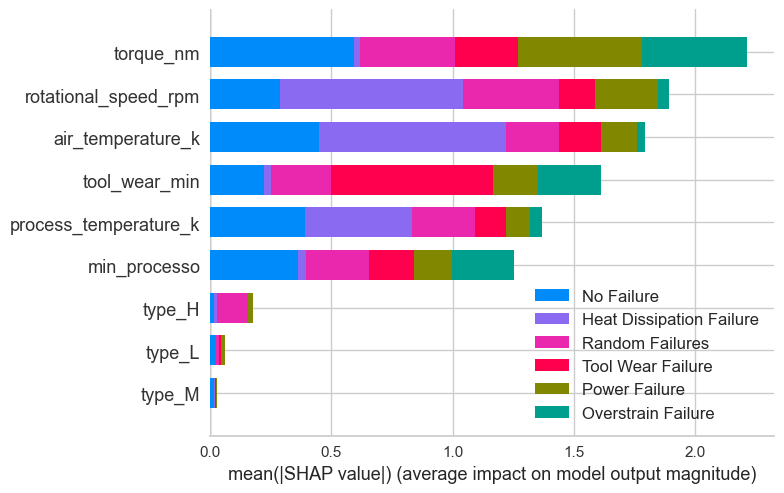

In [57]:
# Suponha que 'response' seja a sua variável de resposta
X = df_treino_dummie.drop('failure_type', axis=1)

# calcular os valores SHAP
explainer = shap.Explainer(lgbm)
shap_values = explainer.shap_values(X)

# definir os nomes das classes
class_names = ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']

# plotar o gráfico de resumo
shap.summary_plot(shap_values, X, class_names=class_names)

- **Torque_nm e rotational_speed_rpm** têm impactos significativos em todos os tipos de falhas, indicando que são variáveis críticas no modelo.
- **Air_temperature_k e tool_wear_min** também influenciam várias falhas, mas com menor intensidade comparado ao torque e velocidade rotacional.
- **Process_temperature_k** tem um impacto notável apenas na falha de dissipação de calor.
- Os valores SHAP para **type_H, type_L, e type_M** são bastante específicos para certos tipos de falhas, sugerindo que essas categorias podem ser indicadores diretos de tipos específicos de falhas.